# Parallel Convolutional Neural Network

In [35]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

For our project we have decided to create a __CNN__, using the package __Numba__, whith which you can write __cuda__ functions while keeping  the python syntax. <br> <br>
We proceeded by taking a fully constructed CNN in numpy here : https://github.com/Alescontrela/Numpy-CNN <br>
After making sure this code was right, we used it as our skeleton to define and use our parrellel functions, that we wrote using Numba.<br>
Once the parallel CNN was build and worked, we designed this notebook to display the results of our implemantation vs the numpy approach and also vs the more commonly known Keras (with tensorflow backend).<br> <br>
The purpose of this notebook is to walk the reader through our code, to show where we encountered problems and the solutions we found. But also to show the optimization process that took place. And to compare our implemantation throughout a range of input sizes.

This repository is made as such :<br/>
> _train-images-idx3-ubyte_ : the __MNSIT__ pictures dataset (60k images of dimensions (28,28)) <br/>
> _train-labels-idx1-ubyte_ : the __labels__ corresponding to the MNSIT <br/>
> _CNN_ : the folder containing the __numpy__ implementation <br/>
> _Nb cnn_ : the folder containing the __Numba__ implementation <br/>

Each of the folder is basically made of these scripts:<br/>
>_forward.py_ : all the necessary forward functions (convolution, maxpool, softmax, categorical cross entropy, dense layer) <br/>
>_backward.py_: all the necessary backward functions (same functions as in forward, but for the backward passes) <br/>
>_network.py_ : this is where we define our model, by calling the function from the 2 previous files. And also define the learning structure (with batches definition and so on)<br/>
>_utils.py_<br/>

The first 2 scripts are where the parallelisation happens

In this notebook we will make use of these scripts to try and compare the different approaches on different datasets

## Imports

In [36]:
import keras
from keras.utils import to_categorical
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Reshape, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.advanced_activations import ReLU
from keras.optimizers import Adam
import time
t_very_start = time.time()

In [37]:
from CNN.network import train_cnn_np                ## The CNN build with numpy
from Nb_cnn.network_3 import train_cnn_nb           ## The CNN build with numpy

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import timeit
from tqdm import tqdm
import math

from numba import cuda
from Nb_cnn.forward import convolution

__The cell below is just here to show what the final CNN is__

In [39]:
def build_model(summa = False):
    model = Sequential()
    model.add(Conv2D(filters = 8, kernel_size = (5, 5)))
    model.add(ReLU())
    model.add(Conv2D(filters = 8, kernel_size = (5, 5)))
    model.add(ReLU())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(ReLU())
    model.add(Flatten())
    model.add(Dense(128, use_bias=False))
    model.add(ReLU())
    model.add(Dense(10, activation="softmax", use_bias=False))
    picture = Input(shape=(28,28,1))
    pred_prob = model(picture)
    if summa == True:
        model.summary()
    return Model(picture, pred_prob)
model = build_model(summa = True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 24, 24, 8)         208       
_________________________________________________________________
re_lu_9 (ReLU)               (None, 24, 24, 8)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 20, 20, 8)         1608      
_________________________________________________________________
re_lu_10 (ReLU)              (None, 20, 20, 8)         0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 10, 10, 8)         0         
_________________________________________________________________
re_lu_11 (ReLU)              (None, 10, 10, 8)         0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 800)               0         
__________

## Dive in our work

In this section we will go through some of our parrallel functions. Some quite straightforward, so you get the gist of how it works, but also and mainly over the ones that caused us the more trouble

### Forward

#### Convolution
This function takes as input the image, the filter, the bias and a "placeholder" for the output. <br/> 
Numba function with the decorator "@cuda.jit" allow us to parallelize like we want, but it can only return void. So we feed it the output as well as the input. <br/>
For simplicity we only apply square window convolution, meaning filter is of size (f1,f2) with f1 = f2. And we also only ever apply stride of 1 with no padding.

Here, we parrallelize through 3 dimensions : the channel, the height and the width. This is very useful to write code in a more natural way. We apply the filter on the part of the image selected, we sum up the result and then check if it's positive or not. If it's positive we keep it as such, if it's negative we then clip it to zero (this is the RELu activation function). <br/>
Finally, we "feed" the result to the output.

In [40]:
@cuda.jit
def convolution(image, filt, bias, out):
    startX, startY, startZ = cuda.grid(3)          ### We parrallelize on 3 dimensions :
    gridX = cuda.gridDim.x * cuda.blockDim.x;      ### Dimension 1
    gridY = cuda.gridDim.y * cuda.blockDim.y;      ### Dimension 2
    gridZ = cuda.gridDim.z * cuda.blockDim.z;      ### Dimension 3
    (n_f, n_c_f, f, _) = filt.shape
    in_dim = image.shape[-1]
    for curr_f  in range(startX, n_f, gridX):      ### Parrallelize over the number of filters
        b_f = bias[curr_f]
        w_f = filt[curr_f]
        for curr_y in range(startY, in_dim-f+1, gridY):      ### Parrallelize over height of the picture
            for curr_x in range(startZ, in_dim-f+1, gridZ):      ### Parrallelize over width of the picture
                summ = 0.
                im_part = image[:,curr_y:curr_y+f, curr_x:curr_x+f] 
                ### After this point is not parrallel; we wanna sum the product of the filter by the designated picture part
                for kk in range(w_f.shape[-3]):
                    for ii in range(w_f.shape[-2]):
                        for jj in range(w_f.shape[-1]):
                            summ += w_f[kk][ii][jj] * im_part[kk][ii][jj]
                summ += b_f[0]
                ##apply RELu
                if summ >= 0. :
                    out[curr_f, curr_y, curr_x] = summ
                else:
                    out[curr_f, curr_y, curr_x] = 0.

#### Dense / Fully Connected
This function takes as input the previous layer output (flat vector), the weight (a 2d matrix), a "placeholder" for the output and a boolean to determine if we apply RELu activation or not. <br/> 

This time, we parrallelize on 1 dimension : the output vector. For every row of the weight matrix, we compute the dot product between the given row and the input (previous layer). We then apply the RELu activation (or not depending on the value of the argument "relu") and finally feed it to the output.

In [41]:
@cuda.jit
def dense_lay(A, B, C, relu):    
    startX = cuda.grid(1)
    gridX = cuda.gridDim.x * cuda.blockDim.x;
    for jj in range(startX, C.shape[0] ,gridX):      ### Parrallelize over the output vector
        summ = 0.
        B_jj = B[jj]
        for kk in range(A.shape[0]):
            summ += A[kk][0] * B_jj[kk]
        ##apply RELu
        if relu:
            if summ <= 0. :
                summ = 0.
        C[jj,0] = summ

### Backward

The backward operation caused us more problems to parallelize. And so fisrt we will look at the implementation on numpy and then at the one on numba.

#### ReLU
Let's write "$dconv_l$" the gradient of the loss backpropagated throught the layer $l$, and "$conv_l$" the same layer but during the forward pass. Then, to backpropagate through ReLU, in Numpy all we need do is :
>$dconv_l[conv_l<=0] = 0$

Below is the equivalent for a 1d vector. This is the function used to backpropagate through ReLU the gradient of a dense layer. <br/> There is also the equivalent function for 3d vectors, useful to do the same but for the gradient of a convolutionnal layer.

We parrallelize through the vectors to apply the ReLU condition element wise

In [42]:
@cuda.jit
def back_RELu(A, B):
    startX = cuda.grid(1)
    gridX = cuda.gridDim.x * cuda.blockDim.x;
    for ii in range(startX, A.shape[0] ,gridX):
        if A[ii][0] <= 0.:
            B[ii][0] = 0.

#### Dense, layer gradient
Here we compute the gradient of the loss w.r.t. a dense/fully connected layer.<br/>
Let's write that $dout_l$ is the gradient of the layer $l$, and $weight_{l}$ is the matrix weight of the layer $l$. Then in Numpy the backpropagation can be done using only this line :
>$dout_l$ = $weight_{l+1}$.T.dot($dout_{l+1}$) ; with $A$.T = transpose($A$)

So at first we just used the previoulsy defined function "dense_lay" (showed above) like so:
>dense_lay($dout_{l+1}$, $weight_{l+1}$.T, $dout_l$, False)

Surprisingly, this layer took a lot more time to run than other layers (around 20 times more). After a fair bit of investigation, we realised that it was entirely due to the operation $weight_{l+1}$.T <br/>
Transposing a vector, even a very small one, on the gpu is a lot more longer than on the cpu. So, based on that discovery we just created the function below

Basically we removed the necessity to transpose the weight matrix, simply by switching the axis on which we do the dot product, see here it's :
> B[kk,jj] and not B[jj,kk] like before

This may seem like nothing but it took quite a while to discover where the bottleneck was.

In [43]:
@cuda.jit
def back_dense_lay_grad(A, B, C):    
    startX = cuda.grid(1)
    gridX = cuda.gridDim.x * cuda.blockDim.x;
    for jj in range(startX, C.shape[0] ,gridX):
        summ = 0.
        for kk in range(A.shape[0]):
            summ += A[kk][0] * B[kk, jj]
        C[jj,0] = summ

#### Convolution, filter's gradient and gradient backpropagation
This backward function is one that troubled us the most. We will look simultaneously at the filters' gradient and at the backpropagation of the loss to the previous layer. These 2 operations can be done simultaneously in numpy, but cannot in numba. <br/>
Let's first look quickly at the numpy implementation. Here, the arguments are :
> *dconv_prev* is the gradient of the layer l+1 <br/>
> *conv_in* is the forward pass of the layer l  <br/>
> *filt* is the filter of the layer l+1  <br/>
> *s* is the stride (always equal to 1 so no need to pay it to much attention)

In [44]:
def convolutionBackward(dconv_prev, conv_in, filt, s):
    (n_f, n_c, f, _) = filt.shape
    (_, orig_dim, _) = conv_in.shape
    ## initialize derivatives
    dout = np.zeros(conv_in.shape)
    dfilt = np.zeros(filt.shape)
    dbias = np.zeros((n_f,1))
    for curr_f in range(n_f):
        # loop through all filters
        curr_y = out_y = 0
        while curr_y + f <= orig_dim:
            curr_x = out_x = 0
            while curr_x + f <= orig_dim:
                # loss gradient of filter (used to update the filter)
                dfilt[curr_f] += dconv_prev[curr_f, out_y, out_x] * conv_in[:, curr_y:curr_y+f, curr_x:curr_x+f] ## real * (n_c, f, f)
                # loss gradient of the input to the convolution operation (conv1 in the case of this network)
                dout[:, curr_y:curr_y+f, curr_x:curr_x+f] += dconv_prev[curr_f, out_y, out_x] * filt[curr_f] ## real * (n_c, f, f)
                curr_x += s
                out_x += 1
            curr_y += s
            out_y += 1
        # loss gradient of the bias
        dbias[curr_f] = np.sum(dconv_prev[curr_f])
    
    return dout, dfilt, dbias

The problem with this approach when we want to parrallelize it are those 2 lines:
```python
dfilt[curr_f] += dconv_prev[curr_f, out_y, out_x] * conv_in[:, curr_y:curr_y+f, curr_x:curr_x+f]
dout[:, curr_y:curr_y+f, curr_x:curr_x+f] += dconv_prev[curr_f, out_y, out_x] * filt[curr_f]
```

And more specifically this "__+=__", the fact that want to accumulate. This numpy based function takes each filter, apply it "backwardly" to a part of the image and accumulate the results throughout the loops. That is something we cannot parrallelize, not this way at least. Because in order for this function to run properly we would need to wait for every product to be made before summing them, here we just sum them over time. <br/> <br/>
When we first tried to naively parrellize this function, we ended up with a function that not only would give us wrong result, but also give us different results at every run. So bellow is the solution we found; we had to devellop 2 functions : one for the gradient of the filter and one for the propagation of the gradient to the previous layer.

##### Filter's gradient

Our solution to computing the gradient of the filter was to parrallelize, not on the picture dimensions, but on the filters dimensions directly. So we had to understand what the final formula of each filter's gradient was in order to do so. That meant that we where on 6 different dimension (6 loop) trying to understand how it all came together in th end. Moving from accumulation over time to exact formula was quite the brain teaser. 

In [45]:
@cuda.jit
def back_conv_filt(dconv_prev, conv_in, dfilt):
    startX, startY, startZ = cuda.grid(3);
    gridX = cuda.gridDim.x * cuda.blockDim.x;
    gridY = cuda.gridDim.y * cuda.blockDim.y;
    gridZ = cuda.gridDim.z * cuda.blockDim.z;
    
    (n_f, n_c, f, _) = dfilt.shape
    (_, orig_dim, _) = conv_in.shape
    for curr_f in range(startX, n_f, gridX):
        for curr_c in range(startY, n_c, gridY):
            for ii in range(startZ, f, gridZ):
                for jj in range(f):
                    summ = 0.
                    for out_y in range(orig_dim-f+1):
                            for out_x in range(orig_dim-f+1):
                                summ += dconv_prev[curr_f, out_y, out_x] * conv_in[curr_c,out_y+ii, out_x+jj]
                    dfilt[curr_f,curr_c,ii,jj] = summ

##### Gradient backpropagation

For the backpropagtion of the gradient to the previous layer, we use the same approach, we parrallelized on the output (the previous layer gradient) dimensions. Giving the fact that, due to the convolution, $dim(dout_l) \neq dim(dout_{l+1})$ we had some problems on the "edge" of the layers, because every "pixel" is not the result of the same number of addition. For example, the very first pixel is equal to :
```python
su = 0
for i in range(filt.shape[0]):
    su+= dconv_prev[i, 0, 0] * filt[i, 0, 0, 0]
dout[0, 0, 0] = su
```
Whereas the next one is :
``` python
su = 0 
for i in range(6):
    su+= (dconv_prev[i, 0, 0] * filt[i, 0, 0, 1] +
          dconv_prev[i, 0, 1] * filt[i, 0, 0, 0])
dout[0, 0, 1] = su
```
And so on... <br/>
But we have to run it this way, otherwise we cannot parrallelize it. So in addition to rearranging the 6 different loops, which was hard enough, we also had to come up with the right "if" conditions to take into account the "edge" problem we just showed <br/>
Bellow is the solution we found

In [46]:
@cuda.jit
def backprop_conv(dconv_prev, filt, dout):
    startX, startY, startZ = cuda.grid(3);
    gridX = cuda.gridDim.x * cuda.blockDim.x;
    gridY = cuda.gridDim.y * cuda.blockDim.y;
    gridZ = cuda.gridDim.z * cuda.blockDim.z;
    
    (n_c, n_c_2, f, _) = filt.shape
    (n_f, orig_dim, _) = dout.shape
    for curr_f in range(startX, n_f, gridX):
        for curr_y in range(startY, orig_dim, gridY):
            for curr_x in range(startZ, orig_dim, gridZ):
                summ = 0.
                for kk in range(n_c):
                    for ii in range(f):
                        for jj in range(f):
                            if (curr_y-f+1+ii < dconv_prev.shape[1] and
                                curr_x-f+1+jj < dconv_prev.shape[2] and
                                curr_y-f+1+ii>=0 and
                                curr_x-f+1+jj>=0 and 
                                f-1-ii >=0 and
                                f-1-jj >=0) :
                                summ += dconv_prev[kk, curr_y-f+1+ii, curr_x-f+1+jj] * filt[kk,curr_f,f-1-ii,f-1-jj]
                dout[curr_f, curr_y, curr_x] = summ

## Optimizing our model

### Grid and Block Dimension

Once all the necessary forward and backward functions are written this is how you would use those:
``` python
from numba import cuda
import numpy as np
from Nb_cnn.utils import initializeFilter

## Initialize the parameters but also the output layer
filt_1 = initializeFilter(size = size_of_first_filter)
b1 = np.zeros((size_of_first_filter[0],1))
out_1 = np.zeros((size_of_first_filter[0], out_dim_1, out_dim_1))


## Load the arrays to the gpu memory (the 'device')
d_image = cuda.to_device(image)
d_filter_1 = cuda.to_device(filt_1)
d_b1 = cuda.to_device(b1)
d_out_1 = cuda.to_device(out_1)

## Apply the function like so :
convolution[(8,8,8), (2,8,16)](d_image, d_filter_1, d_b1, d_out_1)
```
Here (8,8,8) corresponds to the grid dimension and (2,8,16) to the block dimension <br/>
__The purpose of this section is to try to optimize these 2 values__

Notice that every one of our parrallelized function starts something like this:
``` python
startX, startY, startZ = cuda.grid(3);
gridX = cuda.gridDim.x * cuda.blockDim.x;
gridY = cuda.gridDim.y * cuda.blockDim.y;
gridZ = cuda.gridDim.z * cuda.blockDim.z;
```
Here is the documentation on these, numba.cuda.grid(ndim):
>Return the absolute position of the current thread in the entire grid of blocks. ndim should correspond to the number of dimensions declared when instantiating the kernel. If ndim is 1, a single integer is returned. If ndim is 2 or 3, a tuple of the given number of integers is returned.

numba.cuda.blockDim :
>The shape of the block of threads, as declared when instantiating the kernel. This value is the same for all threads in a given kernel, even if they belong to different blocks (i.e. each block is “full”)

numba.cuda.gridDim :
>The shape of the grid of blocks, i.e. the total number of blocks launched by this kernel invocation, as declared when instantiating the kernel.

The big problem when we want to compare 2 runs of the same function, with different grid dimension for example, is the unstability. <br/>
The example below speaks for itself :

In [47]:
BLOCKDIM_3D = (2, 8, 16)

s = """\
from __main__ import test_conv
import numpy as np
import math
from Nb_cnn.forward import convolution
from numba import cuda
BLOCKDIM_3D = (2, 8, 16)
pic_dim = 512
image = np.random.normal(size = (1,pic_dim,pic_dim)); d_image = cuda.to_device(image)
filt = np.random.normal(size = (4,image.shape[0],5,5)); d_filt = cuda.to_device(filt)
b = np.random.normal(size = (4,1)); d_b = cuda.to_device(b)
out_dim_1 = image.shape[1] - filt.shape[-1] + 1
out = np.random.normal(size = (4, out_dim_1, out_dim_1)); d_out = cuda.to_device(out)
blockspergrid_x = math.ceil(d_filt.shape[0] / BLOCKDIM_3D[0])
blockspergrid_y = math.ceil((d_image.shape[-1] - d_filt.shape[-2]+1) / BLOCKDIM_3D[1])
blockspergrid_z = math.ceil((d_image.shape[-1] - d_filt.shape[-2]+1)/ BLOCKDIM_3D[2])
blockspergrid = (blockspergrid_x, blockspergrid_y, blockspergrid_z)
    """

def test_conv(d_image, d_filt, d_b, d_out, blockspergrid):
    if blockspergrid:
        convolution[blockspergrid, BLOCKDIM_3D](d_image, d_filt, d_b, d_out) ## adapted dimension
    else : 
        convolution[(8,8,8), BLOCKDIM_3D](d_image, d_filt, d_b, d_out) ## random dimension choosen

        
for i in range(10):    
    opt = timeit.timeit("test_conv(d_image, d_filt, d_b, d_out, blockspergrid)", number=1000, setup=s)
    no_opti = timeit.timeit("test_conv(d_image, d_filt, d_b, d_out, None)", number=1000, setup=s)
    if opt < no_opti:
        print(i, "Adapting the grid dimension is better, time difference :", opt - no_opti)
    else:
        print(i, "Adapting the grid dimension is not better, time difference :", opt - no_opti)

0 Adapting the grid dimension is not better, time difference : 0.43928798567048943
1 Adapting the grid dimension is better, time difference : -0.008185787137335865
2 Adapting the grid dimension is better, time difference : -0.088572572598423
3 Adapting the grid dimension is better, time difference : -0.0026303774502594024
4 Adapting the grid dimension is better, time difference : -0.041535020159244596
5 Adapting the grid dimension is better, time difference : -0.0400136095504422
6 Adapting the grid dimension is better, time difference : -0.018614305635310302
7 Adapting the grid dimension is not better, time difference : 0.03705940357212967
8 Adapting the grid dimension is better, time difference : -0.06634400508755789
9 Adapting the grid dimension is better, time difference : -0.0024812266974549857


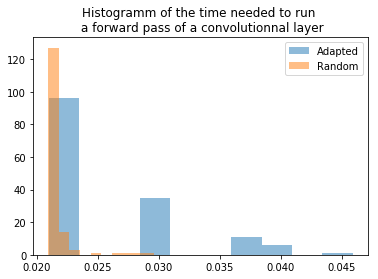

In [48]:
### Let's try a more empirical approach to determine the best grid dimension:
import matplotlib.pyplot as plt

times_opt = timeit.repeat("test_conv(d_image, d_filt, d_b, d_out, blockspergrid)", number=100, setup=s, repeat = 150)[1:]
times_no = timeit.repeat("test_conv(d_image, d_filt, d_b, d_out, None)", number=100, setup=s, repeat = 150)[1:]

plt.hist(times_opt, alpha = 0.5)
plt.hist(times_no, alpha = 0.5)
plt.legend(["Adapted","Random"])
plt.title("Histogramm of the time needed to run \n a forward pass of a convolutionnal layer")
plt.show()

As we can see, sometimes adapting the grid dimension to the input shape is better, sometimes it's not, it's not so clear which is really better. It seems that adapted dimension performed the best runs. If you run this cell, you will get different results every time, so you cannot really say anything about this approach unfortunately

### Varying the size of the input

Here the purpose is to look at the same problem as above, but this time, we are going to make the size of the input vary to see how that would impact the speed run but also the "instability" we just showed.

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import timeit
import time
from tqdm import tqdm
from Nb_cnn.forward import convolution

In [50]:
BLOCKDIM_3D = (1, 16, 16)
def def_context(pic_dim):
    s = """\
from __main__ import test_conv
import numpy as np
import math
from Nb_cnn.forward import convolution
from numba import cuda
BLOCKDIM_3D = (1, 16, 16)
pic_dim = """ + str(pic_dim) + """;
image = np.random.normal(size = (pic_dim[0],pic_dim[1],pic_dim[1])); d_image = cuda.to_device(image)
filt = np.random.normal(size = (8,image.shape[0],5,5)); d_filt = cuda.to_device(filt)
b = np.random.normal(size = (filt.shape[0],1)); d_b = cuda.to_device(b)
out_dim_1 = image.shape[1] - filt.shape[-1] + 1
out = np.random.normal(size = (filt.shape[0], out_dim_1, out_dim_1)); d_out = cuda.to_device(out)
blockspergrid_x = math.ceil(d_filt.shape[0] / BLOCKDIM_3D[0])
blockspergrid_y = math.ceil((d_image.shape[-1] - d_filt.shape[-2]+1) / BLOCKDIM_3D[1])
blockspergrid_z = math.ceil((d_image.shape[-1] - d_filt.shape[-2]+1)/ BLOCKDIM_3D[2])
blockspergrid = (blockspergrid_x, blockspergrid_y, blockspergrid_z)
        """
    return s
def test_conv(d_image, d_filt, d_b, d_out, blockspergrid):
    if blockspergrid:
        convolution[blockspergrid, BLOCKDIM_3D](d_image, d_filt, d_b, d_out) ## adapted dimension
    else : 
        convolution[(8,16,16), BLOCKDIM_3D](d_image, d_filt, d_b, d_out) ## random dimension choosen

The instability remains more than ever, just look at those 2 cells below, they are exactly the same, yet run them one after the other you get quite different results

100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [01:11<00:00,  4.45s/it]


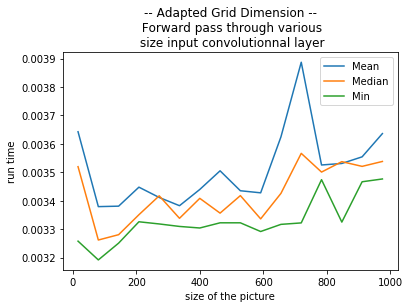

In [51]:
df_1_a = pd.DataFrame()
for i in tqdm(np.arange(16,1024,64)):
    df_1_a[str(i)] = timeit.repeat("test_conv(d_image, d_filt, d_b, d_out, blockspergrid)",
                                         number = 15,
                                         setup = def_context(pic_dim = [3,i]),
                                         repeat = 15)[1:]     ### we remove the first run, since it's always way longer than the other runs
                                                              ### because of the JIT and kernel loading overhead the first time you run it

plt.plot([int(k) for k in df_1_a.mean().index], df_1_a.mean().values)
plt.plot([int(k) for k in df_1_a.median().index], df_1_a.median().values)
plt.plot([int(k) for k in df_1_a.min().index], df_1_a.min().values)
plt.legend(["Mean", "Median", "Min"])    
plt.xlabel("size of the picture")
plt.ylabel("run time")
plt.title("-- Adapted Grid Dimension --\n Forward pass through various\n size input convolutionnal layer")
plt.show()

We varied the size of the input picture through the first convolutionnal layer. We run test with pictures with size ranging in ```np.arange(16,1024,64)```. We run the forward pass 15*15 times and record here the mean, the median and the min value of those runs.

100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [01:11<00:00,  4.49s/it]


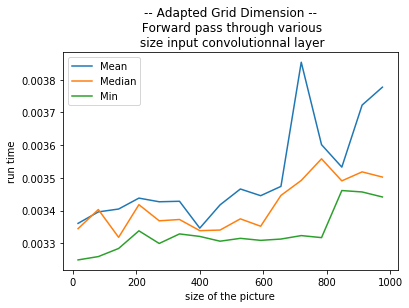

In [52]:
df_2_a = pd.DataFrame()
for i in tqdm(np.arange(16,1024,64)):
    df_2_a[str(i)] = timeit.repeat("test_conv(d_image, d_filt, d_b, d_out, blockspergrid)",
                                         number = 15,
                                         setup = def_context(pic_dim = [3,i]),
                                         repeat = 15)[1:]     ### we remove the first run, since it's always way longer than the other runs
                                                              ### because of the JIT and kernel loading overhead the first time you run it

plt.plot([int(k) for k in df_2_a.mean().index], df_2_a.mean().values)
plt.plot([int(k) for k in df_2_a.median().index], df_2_a.median().values)
plt.plot([int(k) for k in df_2_a.min().index], df_2_a.min().values)
plt.legend(["Mean", "Median", "Min"])    
plt.xlabel("size of the picture")
plt.ylabel("run time")
plt.title("-- Adapted Grid Dimension --\n Forward pass through various\n size input convolutionnal layer")
plt.show()

We didn't find a better or more stable way to look at the efficiency. So unfortunatly we cannot say anything about the speed w.r.t the input size. <br/>
Let's now look at same code, but with the grid dimension fixed, and not depending on the input size. The value choosen is a random one, but a big one :

100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [01:08<00:00,  4.30s/it]


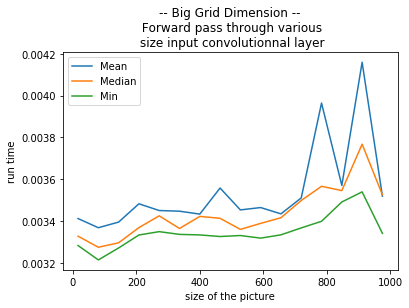

In [53]:

df_1_r = pd.DataFrame()
for i in tqdm(np.arange(16,1024,64)):
    df_1_r[str(i)] = timeit.repeat("test_conv(d_image, d_filt, d_b, d_out, None)",
                                         number = 15,
                                         setup = def_context(pic_dim = [3,i]),
                                         repeat = 15)[1:]     ### we remove the first run, since it's always way longer than the other runs
                                                              ### because of the JIT and kernel loading overhead the first time you run it

plt.plot([int(k) for k in df_1_r.mean().index], df_1_r.mean().values)
plt.plot([int(k) for k in df_1_r.median().index], df_1_r.median().values)
plt.plot([int(k) for k in df_1_r.min().index], df_1_r.min().values)
plt.legend(["Mean", "Median", "Min"])    
plt.xlabel("size of the picture")
plt.ylabel("run time")
plt.title("-- Big Grid Dimension --\n Forward pass through various\n size input convolutionnal layer")
plt.show()

100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [01:07<00:00,  4.23s/it]


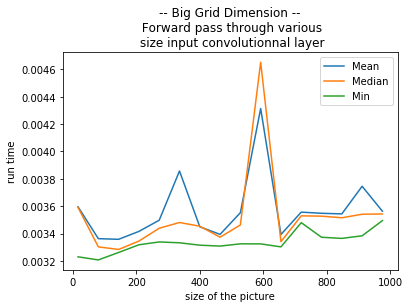

In [54]:
df_2_r = pd.DataFrame()
for i in tqdm(np.arange(16,1024,64)):
    df_2_r[str(i)] = timeit.repeat("test_conv(d_image, d_filt, d_b, d_out, None)",
                                         number = 15,
                                         setup = def_context(pic_dim = [3,i]),
                                         repeat = 15)[1:]     ### we remove the first run, since it's always way longer than the other runs
                                                              ### because of the JIT and kernel loading overhead the first time you run it
plt.plot([int(k) for k in df_2_r.mean().index], df_2_r.mean().values)
plt.plot([int(k) for k in df_2_r.median().index], df_2_r.median().values)
plt.plot([int(k) for k in df_2_r.min().index], df_2_r.min().values)
plt.legend(["Mean", "Median", "Min"])    
plt.xlabel("size of the picture")
plt.ylabel("run time")
plt.title("-- Big Grid Dimension --\n Forward pass through various\n size input convolutionnal layer")
plt.show()    

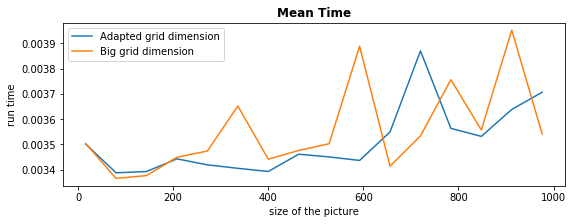

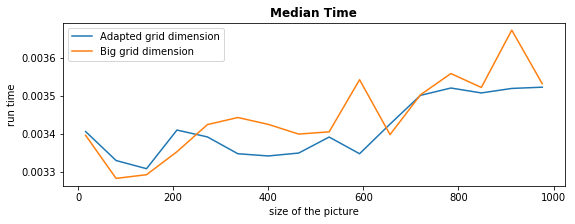

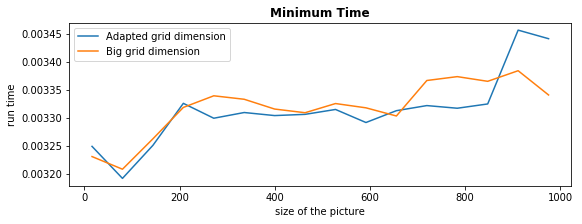

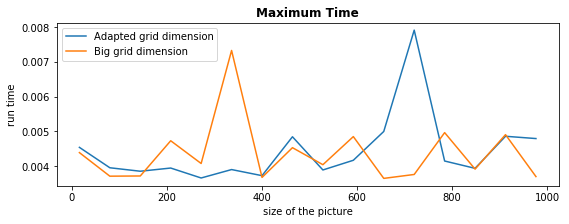

In [55]:
d_a = pd.concat([df_1_a, df_2_a])
d_r = pd.concat([df_1_r, df_2_r])
plt.figure(figsize=(9,3))
plt.plot([int(k) for k in d_a.columns], d_a.mean().values)
plt.plot([int(k) for k in d_r.columns], d_r.mean().values)
plt.legend(["Adapted grid dimension", "Big grid dimension"])
plt.xlabel("size of the picture")
plt.ylabel("run time")
plt.title("Mean Time",fontweight="bold")
plt.show()
plt.figure(figsize=(9,3))
plt.plot([int(k) for k in d_a.columns], d_a.median().values)
plt.plot([int(k) for k in d_r.columns], d_r.median().values)
plt.legend(["Adapted grid dimension", "Big grid dimension"])
plt.xlabel("size of the picture")
plt.ylabel("run time")
plt.title("Median Time",fontweight="bold")
plt.show()
plt.figure(figsize=(9,3))
plt.plot([int(k) for k in d_a.columns], d_a.min().values)
plt.plot([int(k) for k in d_r.columns], d_r.min().values)
plt.legend(["Adapted grid dimension", "Big grid dimension"])
plt.xlabel("size of the picture")
plt.ylabel("run time")
plt.title("Minimum Time",fontweight="bold")
plt.show()
plt.figure(figsize=(9,3))
plt.plot([int(k) for k in d_a.columns], d_a.max().values)
plt.plot([int(k) for k in d_r.columns], d_r.max().values)
plt.legend(["Adapted grid dimension", "Big grid dimension"])
plt.xlabel("size of the picture")
plt.ylabel("run time")
plt.title("Maximum Time",fontweight="bold")
plt.show()

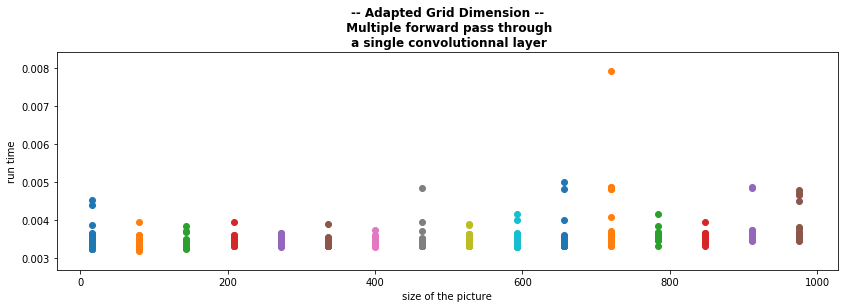

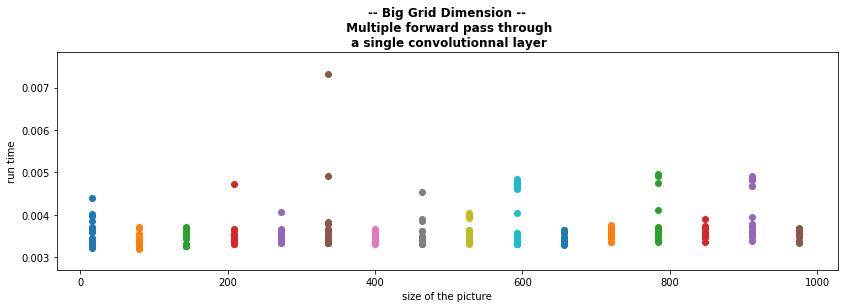

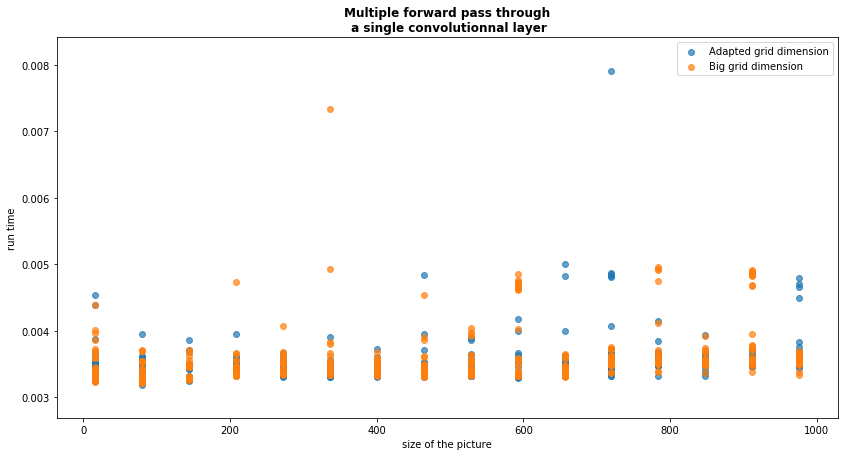

In [56]:
plt.figure(figsize=(14,4))
for pic_dim in d_a.columns:
    plt.scatter([int(pic_dim) * np.ones(d_a.shape[0])], d_a[pic_dim])
plt.ylim((np.min(d_a.values)-0.0005, np.max(d_a.values)+0.0005))
plt.xlabel("size of the picture")
plt.ylabel("run time")
plt.title("-- Adapted Grid Dimension --\n Multiple forward pass through\n a single convolutionnal layer",fontweight="bold")
plt.show()
plt.figure(figsize=(14,4))
for pic_dim in d_r.columns:
    plt.scatter([int(pic_dim) * np.ones(d_r.shape[0])], d_r[pic_dim])
plt.ylim((np.min(d_r.values)-0.0005, np.max(d_r.values)+0.0005))
plt.xlabel("size of the picture")
plt.ylabel("run time")
plt.title("-- Big Grid Dimension --\n Multiple forward pass through\n a single convolutionnal layer",fontweight="bold")
plt.show()
print("\n")
plt.figure(figsize=(14,7))
plt.scatter([int(k) * np.ones(d_a.shape[0]) for k in d_a.columns], [d_a[k] for k in d_a.columns], alpha = 0.7)
plt.scatter([int(k) * np.ones(d_r.shape[0]) for k in d_a.columns], [d_r[k] for k in d_a.columns], alpha = 0.7)
plt.ylim((np.min([d_a.values,d_r.values])-0.0005, np.max([d_a.values,d_r.values])+0.0005))
plt.legend(["Adapted grid dimension", "Big grid dimension"])
plt.xlabel("size of the picture")
plt.ylabel("run time")
plt.title("Multiple forward pass through\n a single convolutionnal layer",fontweight="bold")
plt.show()

It would seem that __most__ (but not all) of the time, adapting the dimension of the grid reduces the run time, but even when it does it is by very little. So between adapting every time the dimension and just putting a big value, we would argue that putting a big value is better for 2 reasons:
1. The gain in runtime obtained by adapting the dimension isn't worth the effort you might put into it
2. This way you ensure that no matter the size of your data, you will never end up out of ressource on your GPU

## Comparing Implementation

In this section we compare the 3 different approaches : 
    1. Keras (more commonly used)
    2. Numpy (baseline)
    3. Numba (our work)

The purpose is to compare, not performance, but efficiency (speed). So we will use the same neural net architecture, and we'll only train on 1 epoch of 5k MNSIT pictures

In [57]:
f1 = (8,1,5,5)     ## (output_channel, input_channel, conv_window_h, window_w)
f2 = (8,8,5,5)     ## (output_channel, input_channel, conv_window_h, conv_window_w)
p3 = (2)           ## pooling window = stride
w4 = (128)          ## neurons on dense layer
nb_classes = (10)  ## number of classes to classify on

In [58]:
GRIDDIM= (8, 16, 32)
BLOCKDIM = (2, 8, 32)
NUM_EPOCHS = 1
BATCH_SIZE = 32

### Keras

In [59]:
from Nb_cnn.utils import extract_data, extract_labels
X = extract_data('train-images-idx3-ubyte.gz', 5000, 28); X-= int(np.mean(X)); X/= np.std(X)
y_dash = extract_labels('train-labels-idx1-ubyte.gz', 5000).reshape(5000,1)
train_data = np.hstack((X,y_dash))
np.random.shuffle(train_data)
X_train = train_data[:,:-1].reshape(5000,28,28,1)
y_train = to_categorical(train_data[:,-1].reshape(5000,1))

Extracting train-labels-idx1-ubyte.gz


In [60]:
def build_model(summa = False):

    model = Sequential()
    
    model.add(Conv2D(filters = f1[0], kernel_size = (f1[2], f1[3])))
    model.add(ReLU())
    model.add(Conv2D(filters = f2[0], kernel_size = (f2[2], f2[3])))
    model.add(ReLU())
    model.add(MaxPooling2D(pool_size=(p3, p3)))
    model.add(ReLU())
    model.add(Flatten())
    model.add(Dense(128, use_bias=False))
    model.add(ReLU())
    model.add(Dense(nb_classes, activation="softmax", use_bias=False))
    picture = Input(shape=(28,28,1))
    pred_prob = model(picture)
    if summa == True:
        model.summary()
    return Model(picture, pred_prob)

model = build_model(summa = True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 24, 24, 8)         208       
_________________________________________________________________
re_lu_13 (ReLU)              (None, 24, 24, 8)         0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 20, 20, 8)         1608      
_________________________________________________________________
re_lu_14 (ReLU)              (None, 20, 20, 8)         0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 10, 10, 8)         0         
_________________________________________________________________
re_lu_15 (ReLU)              (None, 10, 10, 8)         0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 800)               0         
__________

In [61]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=Adam(0.001,  0.00001))
t0 = time.time()
model.fit(X_train, y_train,
          batch_size=BATCH_SIZE,
          epochs=NUM_EPOCHS,
          verbose=0)
t1 = time.time()
keras_time = t1-t0
print("It took keras :", t1-t0,"sec <==> ", (t1-t0)/157,"sec by iteration/batch")

It took keras : 1.7275123596191406 sec <==>  0.01100326343706459 sec by iteration/batch


### Numpy

In [62]:
from CNN.network import train_cnn_np

In [63]:
t0 = time.time()
_ = train_cnn_np(lr = 0.01, img_dim = 28, img_depth = 1, f = f1[-1], num_filt1 = f1[0],
             num_filt2 = f2[0], batch_size = BATCH_SIZE, num_epochs = NUM_EPOCHS, m =5000)
t1 = time.time()
numpy_time = t1-t0
print("It took numpy :", t1-t0,"sec <==> ", (t1-t0)/157,"sec by iteration/batch")

Extracting train-images-idx3-ubyte.gz
Extracting train-labels-idx1-ubyte.gz
LR:0.01, Batch Size:32


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [15:42<00:00,  6.00s/it]


It took numpy : 942.3897733688354 sec <==>  6.0024826329225185 sec by iteration/batch


### Numba

In [64]:
from Nb_cnn.network_3 import train_cnn_nb
import time

Learning Rate = 0.035
Number of epochs = 1
Batch Size = 32
Extracting train-labels-idx1-ubyte.gz


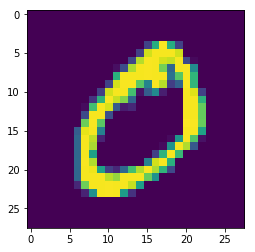

Train Data size = 5000
Weights shapes = [(8, 1, 5, 5), (8, 1), (8, 8, 5, 5), (8, 1), (128, 800), (10, 128)]
Number of weights = [200, 8, 1600, 8, 102400, 1280] Total = 105496


Cost: 0.71067656: 100%|██████████████████████████████████████████████████████████████| 157/157 [00:44<00:00,  3.50it/s]


It took our numba implementation : 45.401121854782104 sec <==>  0.28917912009415353 sec by iteration/batch


In [65]:
t0 = time.time()
train_cnn_nb(lr = 0.035, m = 5000,
             img_dim = 28, NUM_EPOCHS = NUM_EPOCHS, batch_size = BATCH_SIZE,
             nb_classes = nb_classes, f1 = f1, f2 = f2, p3 = p3, w4 = w4,
             test_results = False)
t1 = time.time()
numba_time = t1-t0
print("It took our numba implementation :", t1-t0,"sec <==> ", (t1-t0)/157,"sec by iteration/batch")

__The Keras implementation is by very far the fastest !__

## Running it until it converges

__The purpose of this section is to prove that our CNN does in fact converge__

Learning Rate = 0.02
Number of epochs = 5
Batch Size = 124
Extracting train-labels-idx1-ubyte.gz


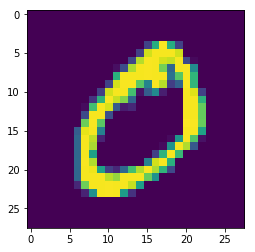

Train Data size = 58976
Weights shapes = [(8, 1, 3, 3), (8, 1), (16, 8, 2, 2), (16, 1), (64, 2304), (10, 64)]
Number of weights = [72, 8, 512, 16, 147456, 640] Total = 148704


Cost: 2.30261583:   0%|                                                                        | 0/476 [00:01<?, ?it/s]

Mean test loss = 2.302577279


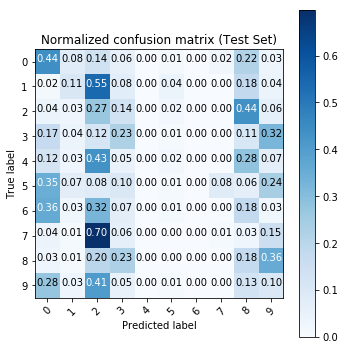

Cost: 2.30140885:  11%|██████▌                                                        | 50/476 [01:03<08:59,  1.27s/it]

Mean test loss = 2.30153965153


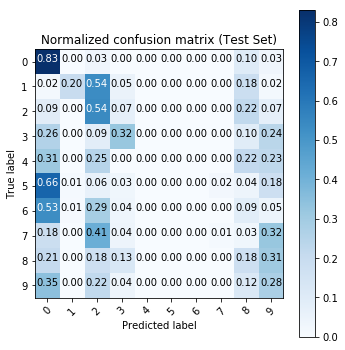

Cost: 2.30008694:  21%|█████████████                                                 | 100/476 [02:05<07:51,  1.25s/it]

Mean test loss = 2.29996049956


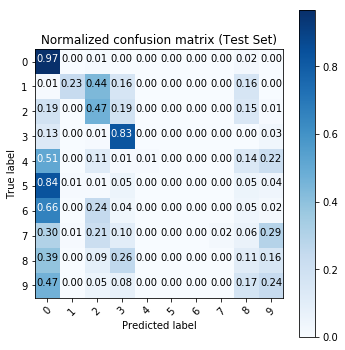

Cost: 2.29738181:  32%|███████████████████▌                                          | 150/476 [03:07<06:47,  1.25s/it]

Mean test loss = 2.29675601201


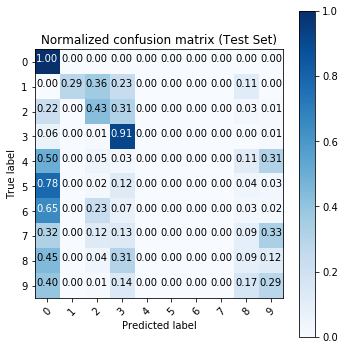

Cost: 2.28676704:  42%|██████████████████████████                                    | 200/476 [04:09<05:44,  1.25s/it]

Mean test loss = 2.28787490306


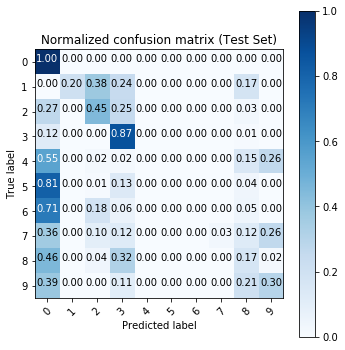

Cost: 2.23636784:  53%|████████████████████████████████▌                             | 250/476 [05:12<04:42,  1.25s/it]

Mean test loss = 2.23898470821


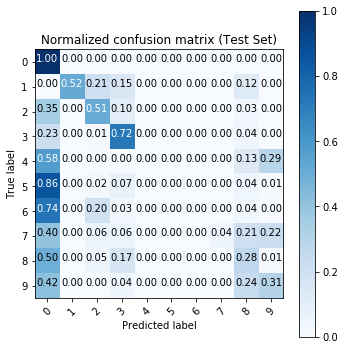

Cost: 1.21599534:  63%|███████████████████████████████████████                       | 300/476 [06:14<03:39,  1.25s/it]

Mean test loss = 1.1476670839


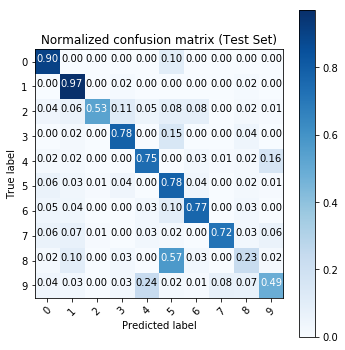

Cost: 0.45728302:  74%|█████████████████████████████████████████████▌                | 350/476 [07:16<02:37,  1.25s/it]

Mean test loss = 0.523290537529


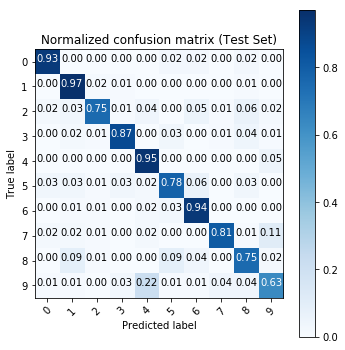

Cost: 0.43664536:  84%|████████████████████████████████████████████████████          | 400/476 [08:18<01:34,  1.25s/it]

Mean test loss = 0.484604780978


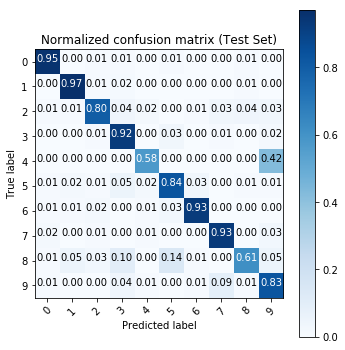

Cost: 0.44171410:  95%|██████████████████████████████████████████████████████████▌   | 450/476 [09:20<00:32,  1.25s/it]

Mean test loss = 0.478376535876


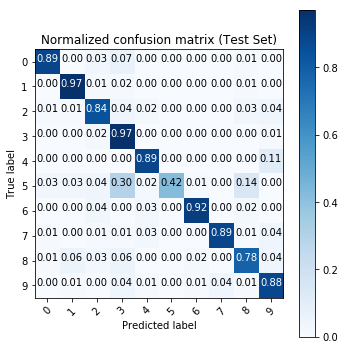

Cost: 0.24694609: 100%|██████████████████████████████████████████████████████████████| 476/476 [09:55<00:00,  1.25s/it]


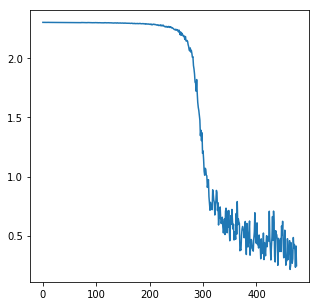

Cost: 0.25170590:   0%|                                                                        | 0/476 [00:01<?, ?it/s]

Mean test loss = 0.378242339847


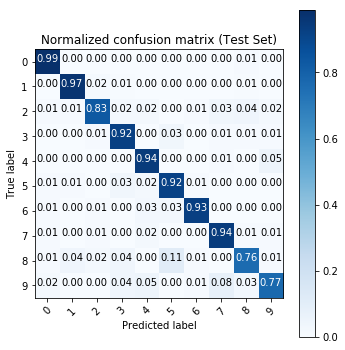

Cost: 0.22252132:  11%|██████▌                                                        | 50/476 [01:03<09:00,  1.27s/it]

Mean test loss = 0.314010784895


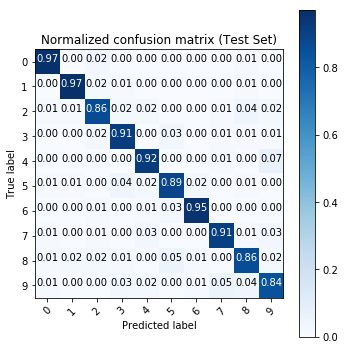

Cost: 0.25309337:  21%|█████████████                                                 | 100/476 [02:05<07:50,  1.25s/it]

Mean test loss = 0.300543549271


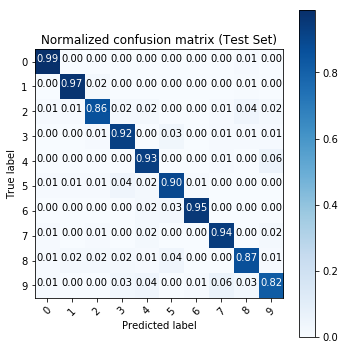

Cost: 0.20935771:  32%|███████████████████▌                                          | 150/476 [03:07<06:47,  1.25s/it]

Mean test loss = 0.289252461773


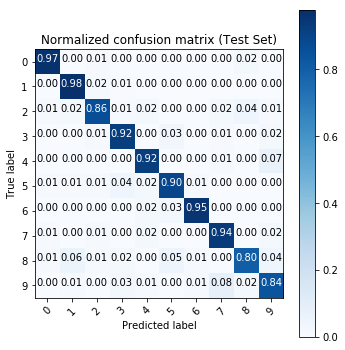

Cost: 0.23890385:  42%|██████████████████████████                                    | 200/476 [04:11<05:46,  1.26s/it]

Mean test loss = 0.269349625393


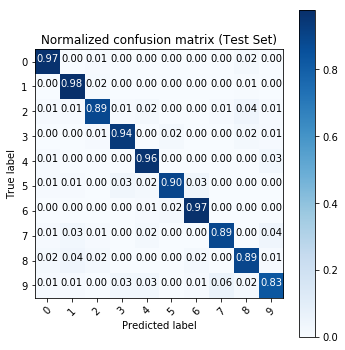

Cost: 0.11579694:  53%|████████████████████████████████▌                             | 250/476 [05:14<04:43,  1.26s/it]

Mean test loss = 0.260086320057


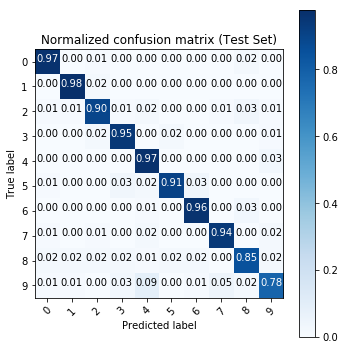

Cost: 0.11658130:  63%|███████████████████████████████████████                       | 300/476 [06:17<03:41,  1.26s/it]

Mean test loss = 0.243626787123


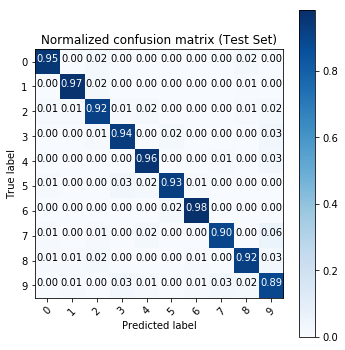

Cost: 0.27633742:  74%|█████████████████████████████████████████████▌                | 350/476 [07:20<02:38,  1.26s/it]

Mean test loss = 0.237020039504


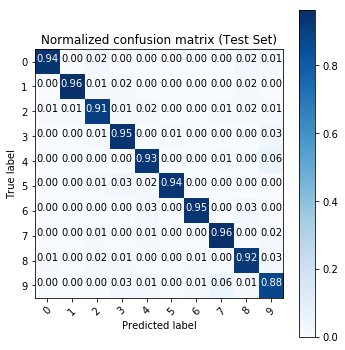

Cost: 0.21723947:  84%|████████████████████████████████████████████████████          | 400/476 [08:23<01:35,  1.26s/it]

Mean test loss = 0.23479178553


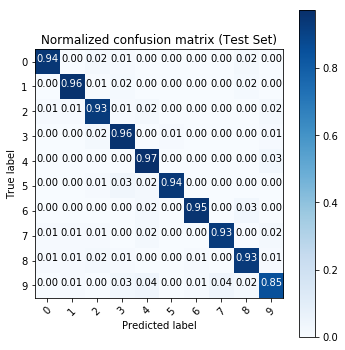

Cost: 0.21875862:  95%|██████████████████████████████████████████████████████████▌   | 450/476 [09:25<00:32,  1.26s/it]

Mean test loss = 0.241653604882


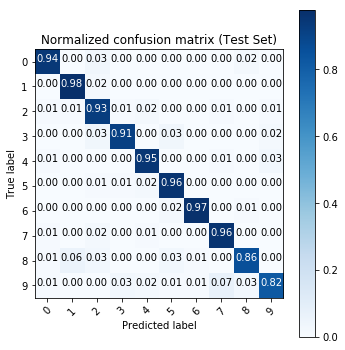

Cost: 0.21412078: 100%|██████████████████████████████████████████████████████████████| 476/476 [10:00<00:00,  1.26s/it]


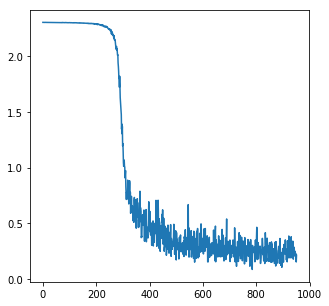

Cost: 0.22477233:   0%|                                                                        | 0/476 [00:01<?, ?it/s]

Mean test loss = 0.217693016219


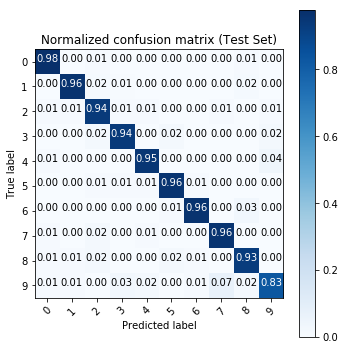

Cost: 0.14881480:  11%|██████▌                                                        | 50/476 [01:03<08:58,  1.26s/it]

Mean test loss = 0.203043041615


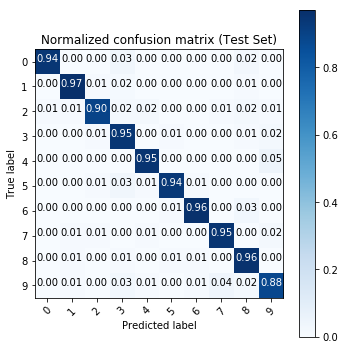

Cost: 0.21396087:  21%|█████████████                                                 | 100/476 [02:05<07:50,  1.25s/it]

Mean test loss = 0.215620650183


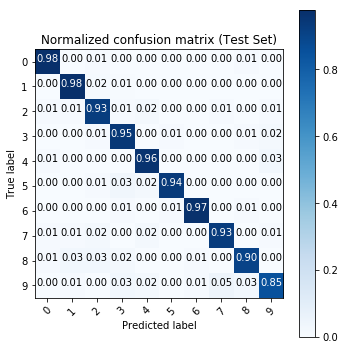

Cost: 0.11187643:  32%|███████████████████▌                                          | 150/476 [03:06<06:46,  1.25s/it]

Mean test loss = 0.204424858901


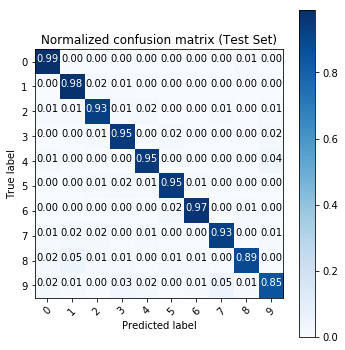

Cost: 0.13576488:  42%|██████████████████████████                                    | 200/476 [04:11<05:46,  1.26s/it]

Mean test loss = 0.190972523819


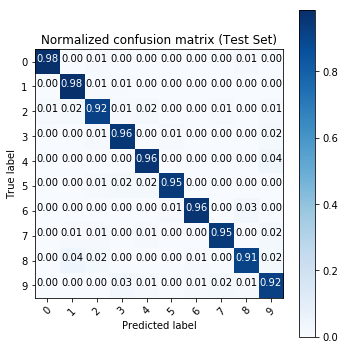

Cost: 0.13706733:  53%|████████████████████████████████▌                             | 250/476 [05:13<04:43,  1.26s/it]

Mean test loss = 0.196856277931


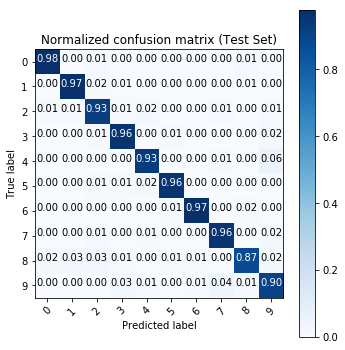

Cost: 0.21140185:  63%|███████████████████████████████████████                       | 300/476 [06:16<03:40,  1.25s/it]

Mean test loss = 0.182036176277


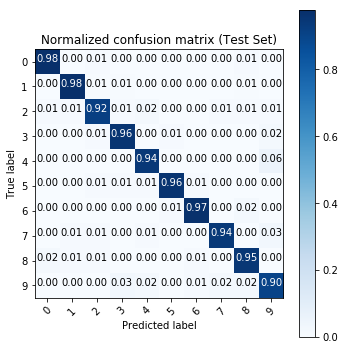

Cost: 0.27142124:  74%|█████████████████████████████████████████████▌                | 350/476 [07:18<02:37,  1.25s/it]

Mean test loss = 0.188619091841


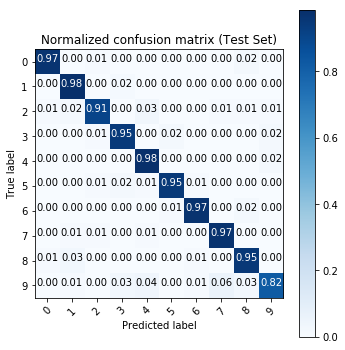

Cost: 0.16344709:  84%|████████████████████████████████████████████████████          | 400/476 [08:21<01:35,  1.25s/it]

Mean test loss = 0.177211874843


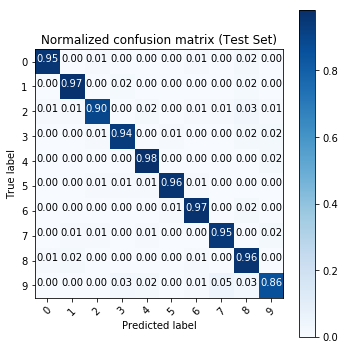

Cost: 0.09217854:  95%|██████████████████████████████████████████████████████████▌   | 450/476 [09:23<00:32,  1.25s/it]

Mean test loss = 0.175988230168


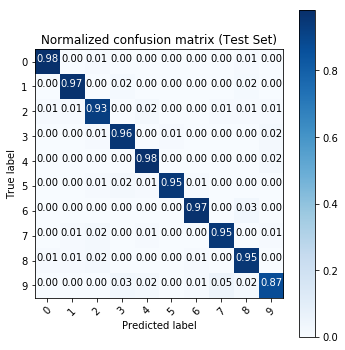

Cost: 0.13608168: 100%|██████████████████████████████████████████████████████████████| 476/476 [09:58<00:00,  1.26s/it]


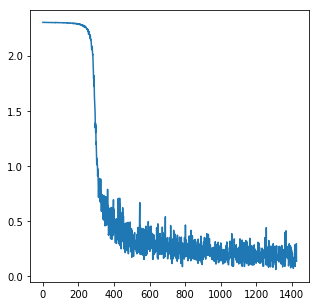

Cost: 0.27609906:   0%|                                                                        | 0/476 [00:01<?, ?it/s]

Mean test loss = 0.174328391177


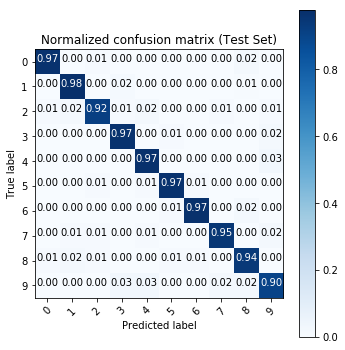

Cost: 0.20869479:  11%|██████▌                                                        | 50/476 [01:06<09:29,  1.34s/it]

Mean test loss = 0.171014135265


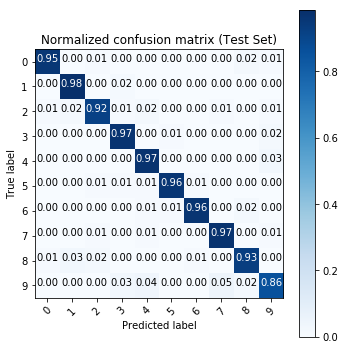

Cost: 0.19448999:  21%|█████████████                                                 | 100/476 [02:09<08:05,  1.29s/it]

Mean test loss = 0.166462949377


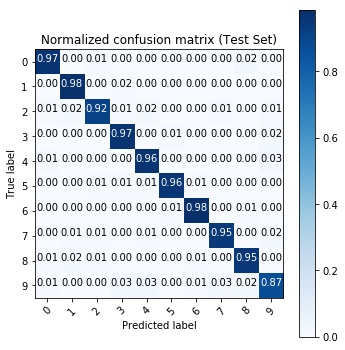

Cost: 0.18622900:  32%|███████████████████▌                                          | 150/476 [03:11<06:56,  1.28s/it]

Mean test loss = 0.171435465585


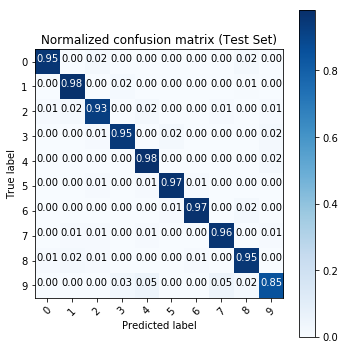

Cost: 0.07182690:  42%|██████████████████████████                                    | 200/476 [04:15<05:52,  1.28s/it]

Mean test loss = 0.163228628409


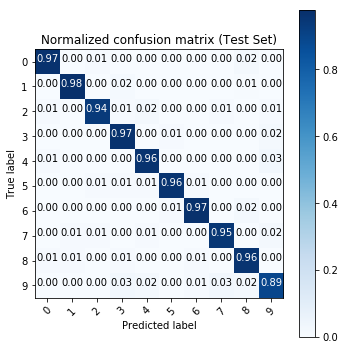

Cost: 0.30597007:  53%|████████████████████████████████▌                             | 250/476 [05:17<04:47,  1.27s/it]

Mean test loss = 0.162988552177


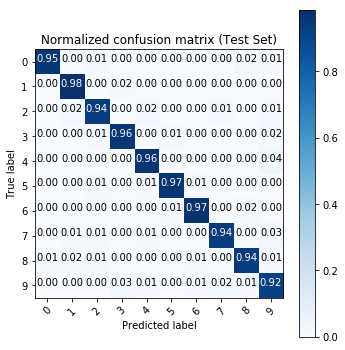

Cost: 0.22371641:  63%|███████████████████████████████████████                       | 300/476 [06:19<03:42,  1.27s/it]

Mean test loss = 0.162291009389


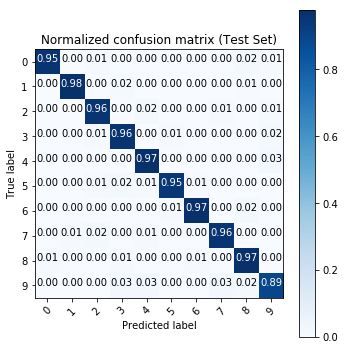

Cost: 0.19992232:  74%|█████████████████████████████████████████████▌                | 350/476 [07:21<02:39,  1.26s/it]

Mean test loss = 0.16159755664


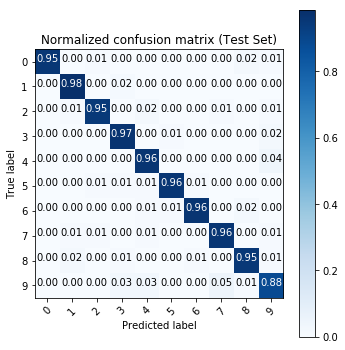

Cost: 0.07560148:  84%|████████████████████████████████████████████████████          | 400/476 [08:23<01:35,  1.26s/it]

Mean test loss = 0.160311803662


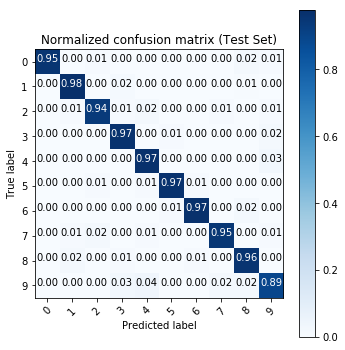

Cost: 0.16784423:  95%|██████████████████████████████████████████████████████████▌   | 450/476 [09:25<00:32,  1.26s/it]

Mean test loss = 0.154159498922


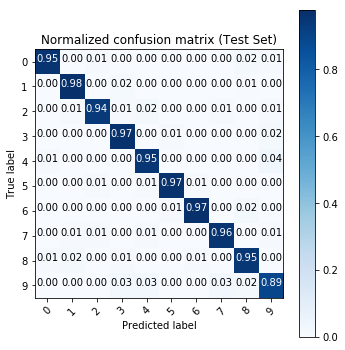

Cost: 0.24143744: 100%|██████████████████████████████████████████████████████████████| 476/476 [10:00<00:00,  1.26s/it]


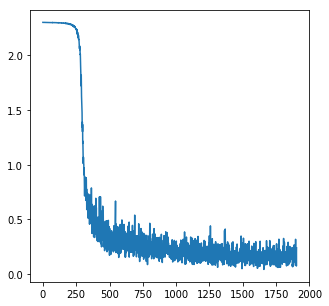

Cost: 0.10725060:   0%|                                                                        | 0/476 [00:01<?, ?it/s]

Mean test loss = 0.157695658571


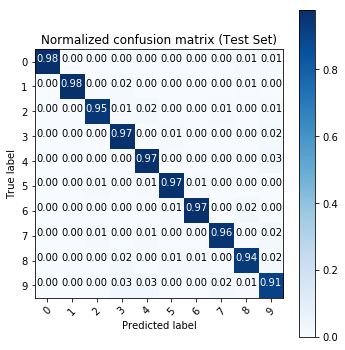

Cost: 0.17122974:  11%|██████▌                                                        | 50/476 [01:03<08:58,  1.26s/it]

Mean test loss = 0.154096402201


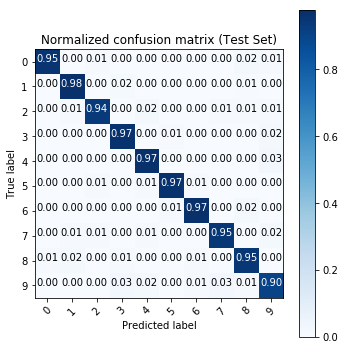

Cost: 0.21472134:  21%|█████████████                                                 | 100/476 [02:05<07:50,  1.25s/it]

Mean test loss = 0.155240393499


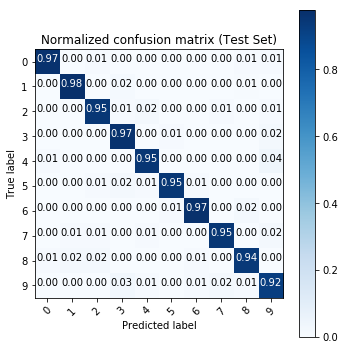

Cost: 0.11772869:  32%|███████████████████▌                                          | 150/476 [03:06<06:45,  1.25s/it]

Mean test loss = 0.153489271353


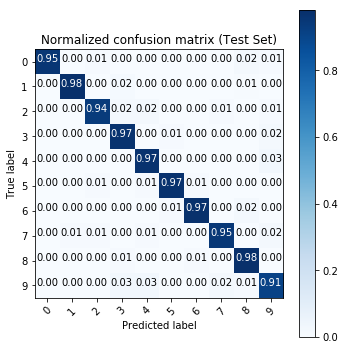

Cost: 0.08808026:  42%|██████████████████████████                                    | 200/476 [04:08<05:43,  1.24s/it]

Mean test loss = 0.153737785503


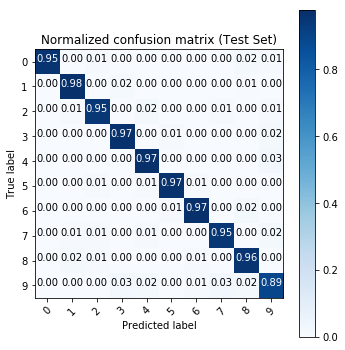

Cost: 0.15042077:  53%|████████████████████████████████▌                             | 250/476 [05:11<04:41,  1.24s/it]

Mean test loss = 0.151804606143


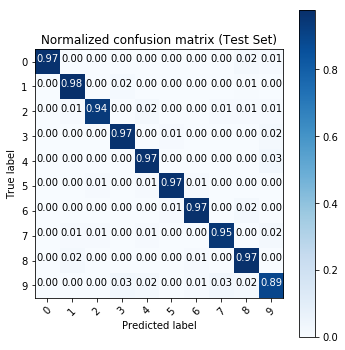

Cost: 0.11008997:  63%|███████████████████████████████████████                       | 300/476 [06:13<03:38,  1.24s/it]

Mean test loss = 0.154496819553


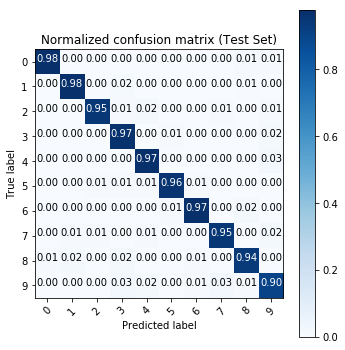

Cost: 0.16977314:  74%|█████████████████████████████████████████████▌                | 350/476 [07:15<02:36,  1.24s/it]

Mean test loss = 0.153639693394


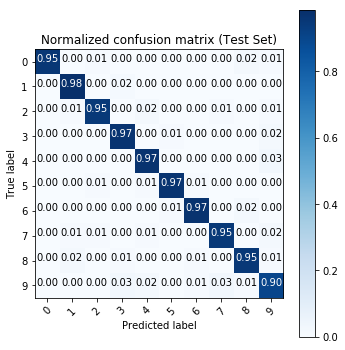

Cost: 0.15377079:  84%|████████████████████████████████████████████████████          | 400/476 [08:17<01:34,  1.24s/it]

Mean test loss = 0.149277030202


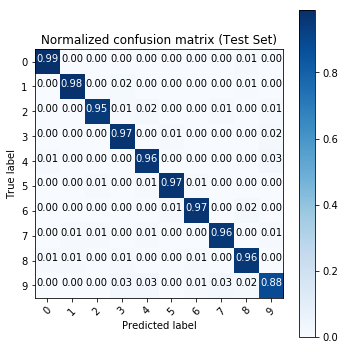

Cost: 0.10452542:  95%|██████████████████████████████████████████████████████████▌   | 450/476 [09:19<00:32,  1.24s/it]

Mean test loss = 0.149599187179


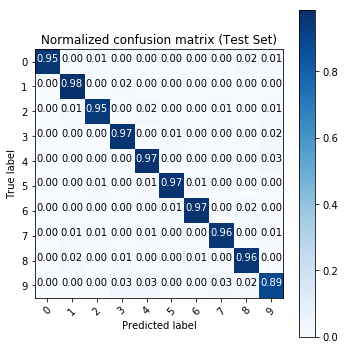

Cost: 0.19527599: 100%|██████████████████████████████████████████████████████████████| 476/476 [09:54<00:00,  1.25s/it]


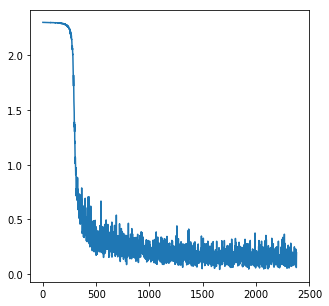

In [66]:
train_cnn_nb(lr = 0.02, m = 60000,
             img_dim = 28, NUM_EPOCHS = 5, batch_size = 124,
             nb_classes = nb_classes, f1 = (8,1,3,3), f2 = (16,8,2,2), p3 = 2, w4 = 64,
             test_results = True)

In [67]:
t_final = time.time()
print("It took",int((t_final -t_very_start)/60),"minutes to run this notebook fully")

It took 72 minutes to run this notebook fully
